In [21]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from experiment import solve_value_function, solve_alternative_ME
from model import ode_y, ode_y_jump_approach_one_boundary, uncertainty_decomposition
from simulation import simulation
from utilities import find_nearest_value
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [22]:
ξ_w=100_000.
ξ_p=5.
ξ_a=1./100

damage_setting={'γ_2p': np.array([0, .0197*2, .3853*2]),
                'πd_o': np.array([1./3, 1./3, 1./3])}
# damage_setting={'γ_2p': np.array([0, .0197*2, .3853*2]),
#                 'πd_o': np.array([.45, .45, .1])}

# Solve for value function, baseline case
model_i_baseline, model_baseline = solve_value_function(100_000., 100_000., 100_000., damage_setting)
# Sovle for value function, distorted case
model_i, model = solve_value_function(ξ_w, ξ_p, ξ_a, damage_setting)

n_damage = len(damage_setting['πd_o'])
y_bar = model['y_grid'][-1]
y_grid_short = model['y_grid']
y_grid_long = model_i[0]['y_grid']

# Simulation
et, yt, ht, gt = simulation(model['y_grid'], model['e_tilde'], model['h'], model['g'],
                            θ=np.mean(model['θ']), y_start=np.mean(model['θ'])*290, T=100)
et_baseline, yt_baseline, _, _ \
               = simulation(model_baseline['y_grid'], model_baseline['e_tilde'],
                            model_baseline['h'], model_baseline['g'],
                            θ=np.mean(model['θ']), y_start=np.mean(model['θ'])*290, T=100)
yt_i = []
ht_i = []
for i in range(n_damage):
    _, y_temp, h_temp, _ = simulation(y_grid_long, model_i[i]['e_tilde'], model_i[i]['h'],
                               np.zeros_like(model_i[0]['e_tilde']).reshape(1, -1), θ=np.mean(model['θ']),
                               y_start=np.mean(model['θ'])*290, T=100)
    yt_i.append(y_temp)
    ht_i.append(h_temp)

Converged. Total iteration 5000: LHS Error: 0.00011794573695667054; RHS Error 6.681372455581702e-05
Converged. Total iteration 1501: LHS Error: 9.932937805601227e-09; RHS Error 0.0004825812927628306
Converged. Total iteration 1619: LHS Error: 9.868386996458867e-09; RHS Error 0.0022617539616424306
Converged. Total iteration 372: LHS Error: 8.939528228779636e-09; RHS Error 0.0006258279853032234
Converged. Total iteration 5000: LHS Error: 4.183515303690655e-05; RHS Error 9.117047385512334e-05
Converged. Total iteration 1507: LHS Error: 9.965610114903711e-09; RHS Error 0.00047002697355678913
Converged. Total iteration 1621: LHS Error: 9.952280777270062e-09; RHS Error 0.0022788046860334884
Converged. Total iteration 443: LHS Error: 9.764197450579104e-09; RHS Error 0.0008703168687622803


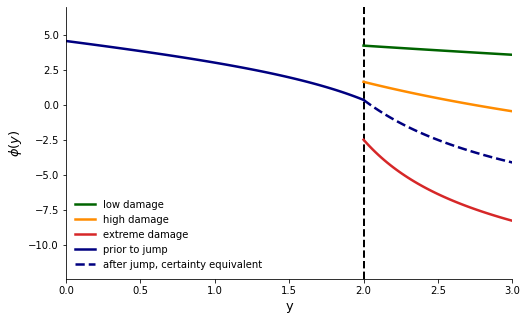

In [23]:
# 1. Plot value function
temp = np.array([res['v0'] for res in model_i])
certainty_equivalent = -ξ_p*np.log(np.average(np.exp(-1./ξ_p*temp), axis=0, weights=damage_setting['πd_o']))

plt.figure(figsize=(8, 5))
plt.plot(y_grid_long[y_grid_long>=y_bar], model_i[0]['v0'][y_grid_long>=y_bar],
         color='darkgreen', linewidth=2.5, label='low damage')
plt.plot(y_grid_long[y_grid_long>=y_bar], model_i[1]['v0'][y_grid_long>=y_bar],
         color='darkorange', linewidth=2.5, label='high damage')
if n_damage == 3:
    plt.plot(y_grid_long[y_grid_long>=y_bar], model_i[2]['v0'][y_grid_long>=y_bar],
             color='tab:red', linewidth=2.5, label='extreme damage')
plt.plot(y_grid_short, model['v0'], color='navy', linewidth=2.5, label='prior to jump')
plt.plot(y_grid_long[y_grid_long>=y_bar], certainty_equivalent[y_grid_long>=y_bar],
         color='navy', linewidth=2.5, linestyle='dashed', label='after jump, certainty equivalent')
y_min = np.min(model_i[2]['v0'])*1.2
y_max = np.max(model_i[0]['v0'])*1.2
plt.vlines(2., ymin=y_min, ymax=y_max, color='black', linestyle='dashed', linewidth=2.)
plt.xlim(0, 3.)
plt.ylim(y_min, y_max)
plt.legend(frameon=False)
plt.xlabel('y', fontsize=13)
plt.ylabel(r'$\phi(y)$', fontsize=13)
plt.savefig('../plots/standardized/value_function.pdf')

(0.0, 2.2)

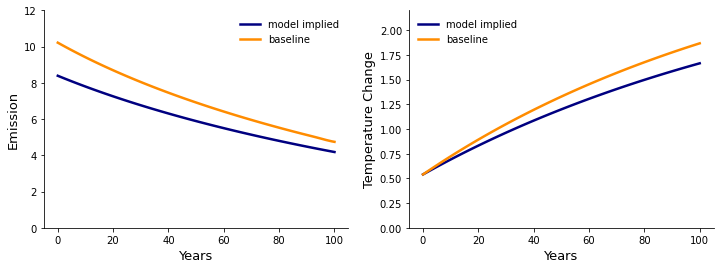

In [4]:
# 2. Plot emission and temperature change
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(et, color='navy', label='model implied', linewidth=2.5)
ax1.plot(et_baseline, color='darkorange', label=r'baseline', linewidth=2.5)
ax1.set_xlabel('Years', fontsize=13)
ax1.set_ylabel('Emission', fontsize=13)
ax1.legend(frameon=False)
ax1.set_ylim(0., int(np.max(et_baseline)*1.2))

ax2.plot(yt, color='navy', label='model implied', linewidth=2.5)
ax2.plot(yt_baseline, color='darkorange', label='baseline', linewidth=2.5)
ax2.set_xlabel('Years', fontsize=13)
ax2.set_ylabel('Temperature Change', fontsize=13)
ax2.legend(frameon=False)
ax2.set_ylim(0., int(np.max(yt_baseline*10)*1.2)/10)

# fig.savefig('../plots/standardized/emission_temperature.pdf')

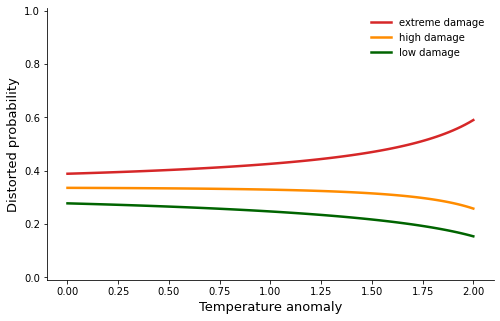

In [5]:
# 3.1 Plot distorted probabilities for damage function, vs y
plt.figure(figsize=(8, 5))
if n_damage == 3:
    plt.plot(y_grid_short, model['g'][2]*damage_setting['πd_o'][2]/np.average(model['g'], weights=damage_setting['πd_o'], axis=0), color='tab:red', label='extreme damage', linewidth=2.5)
plt.plot(y_grid_short, model['g'][1]*damage_setting['πd_o'][1]/np.average(model['g'], weights=damage_setting['πd_o'], axis=0), color='darkorange', label='high damage', linewidth=2.5)
plt.plot(y_grid_short, model['g'][0]*damage_setting['πd_o'][0]/np.average(model['g'], weights=damage_setting['πd_o'], axis=0), color='darkgreen', label='low damage', linewidth=2.5)
plt.xlabel('Temperature anomaly', fontsize=13)
plt.ylabel('Distorted probability', fontsize=13)
plt.ylim(-.01, 1.01)
plt.legend(frameon=False)

# plt.savefig('../plots/standardized/damage_probability.pdf')

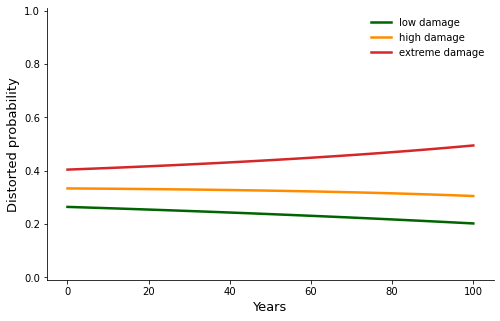

In [6]:
# 3.1 Plot distorted probabilities for damage function
plt.figure(figsize=(8, 5))
plt.plot(gt[0]*damage_setting['πd_o'][0]/np.average(gt, weights=damage_setting['πd_o'], axis=0), color='darkgreen', label='low damage', linewidth=2.5)
plt.plot(gt[1]*damage_setting['πd_o'][1]/np.average(gt, weights=damage_setting['πd_o'], axis=0), color='darkorange', label='high damage', linewidth=2.5)
if n_damage == 3:
    plt.plot(gt[2]*damage_setting['πd_o'][2]/np.average(gt, weights=damage_setting['πd_o'], axis=0), color='tab:red', label='extreme damage', linewidth=2.5)
plt.xlabel('Years', fontsize=13)
plt.ylabel('Distorted probability', fontsize=13)
plt.ylim(-.01, 1.01)
plt.legend(frameon=False)

# plt.savefig('../plots/standardized/damage_probability.pdf')

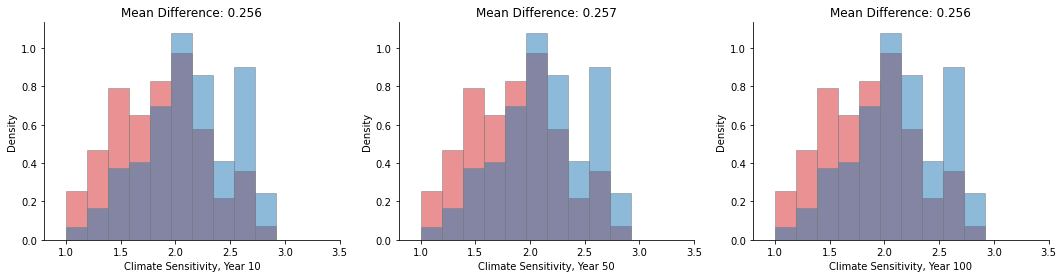

In [7]:
# 3.2 Plot distorted probabilities for climate sensitivity
T_low = 10
T_mid = 50
T_high = 100
loc_low = find_nearest_value(y_grid_short, yt[T_low])
loc_mid = find_nearest_value(y_grid_short, yt[T_mid])
loc_high = find_nearest_value(y_grid_short, yt[T_high])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))

bins = np.linspace(1, 3.5, 14)

ax1.hist(model['θ']*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
ax1.hist((model['θ']+model['σ_y']*ht[T_low])*1000, weights=model['πc'][:, loc_low], bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
ax1.set_xlabel('Climate Sensitivity, Year '+str(T_low))
ax1.set_ylabel('Density')
ax1.set_title('Mean Difference: ' + str(((model['θ']@(model['πc'][:, loc_low])-np.mean(model['θ']))+model['σ_y']*ht[T_low])*1000)[:5])
ax1.set_xlim(.8, 3.5)

ax2.hist(model['θ']*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
ax2.hist((model['θ']+model['σ_y']*ht[T_mid])*1000, weights=model['πc'][:, loc_mid], bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
ax2.set_xlabel('Climate Sensitivity, Year '+str(T_mid))
ax2.set_ylabel('Density')
ax2.set_title('Mean Difference: ' + str(((model['θ']@(model['πc'][:, loc_mid])-np.mean(model['θ']))+model['σ_y']*ht[T_mid])*1000)[:5])
ax2.set_xlim(.8, 3.5)

ax3.hist(model['θ']*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
ax3.hist((model['θ']+model['σ_y']*ht[T_high])*1000, weights=model['πc'][:, loc_high], bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
ax3.set_xlabel('Climate Sensitivity, Year '+str(T_high))
ax3.set_ylabel('Density')
ax3.set_title('Mean Difference: ' + str(((model['θ']@(model['πc'][:, loc_high])-np.mean(model['θ']))+model['σ_y']*ht[T_high])*1000)[:5])
ax3.set_xlim(.8, 3.5)

fig.savefig('../plots/standardized/climate_histogram.pdf')

θ = model['θ']
σ_y = model['σ_y']
# # 3.3.1 Plot distorted probabilities for climate sensitivity conditional on low damage
# fig_names = ['_low_damage.pdf', '_high_damage.pdf', '_extreme_damage.pdf']
# sup_titles = ['Condition on Low Damage', 'Condition on High Damage', 'Condition on Extreme Damage']
# for i in range(n_damage):
#     loc_low = find_nearest_value(y_grid_long, yt_i[i][T_low])
#     loc_mid = find_nearest_value(y_grid_long, yt_i[i][T_mid])
#     loc_high = find_nearest_value(y_grid_long, yt_i[i][T_high])

#     fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))

#     bins = np.linspace(1, 3.5, 14)

#     fig.suptitle(sup_titles[i])
#     ax1.hist(θ*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
#     ax1.hist((θ+σ_y*ht_i[i][T_low])*1000, weights=model_i[i]['πc'][:, loc_low], bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
#     ax1.set_xlabel('Climate Sensitivity, Year '+str(T_low))
#     ax1.set_ylabel('Density')
#     ax1.set_title('Mean Difference: ' + str(((θ@(model_i[i]['πc'][:, loc_low])-np.mean(θ))+σ_y*ht_i[i][T_low])*1000)[:4])
#     ax1.set_xlim(.8, 3.5)

#     ax2.hist(θ*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
#     ax2.hist((θ+σ_y*ht_i[i][T_mid])*1000, weights=model_i[i]['πc'][:, loc_mid], bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
#     ax2.set_xlabel('Climate Sensitivity, Year '+str(T_mid))
#     ax2.set_ylabel('Density')
#     ax2.set_title('Mean Difference: ' + str(((θ@(model_i[i]['πc'][:, loc_mid])-np.mean(θ))+σ_y*ht_i[i][T_mid])*1000)[:4])
#     ax2.set_xlim(.8, 3.5)

#     ax3.hist(θ*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
#     ax3.hist((θ+σ_y*ht_i[i][T_high])*1000, weights=model_i[i]['πc'][:, loc_high], bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
#     ax3.set_xlabel('Climate Sensitivity, Year '+str(T_high))
#     ax3.set_ylabel('Density')
#     ax3.set_title('Mean Difference: ' + str(((θ@(model_i[i]['πc'][:, loc_high])-np.mean(θ))+σ_y*ht_i[i][T_high])*1000)[:4])
#     ax3.set_xlim(.8, 3.5)

#     fig.savefig('../plots/standardized/climate_histogram'+fig_names[i])

In [8]:
ϵ = 5.
η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)

σ_y = 1.2*np.mean(θ)
y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = damage_setting['γ_2p']
πd_o = damage_setting['πd_o']

y_step = .04
y_grid_long = np.arange(0., 4., y_step)
y_grid_short = np.arange(0., 2+y_step, y_step)
n_bar = find_nearest_value(y_grid_long, y_bar) + 1

# Uncertainty decomposition
n_temp = 16
n_carb = 9
θ_reshape = θ.reshape(n_temp, n_carb)
θ_temp = np.mean(θ_reshape, axis=1)
θ_carb = np.mean(θ_reshape, axis=0)
πc_o_temp = np.ones_like(θ_temp)/len(θ_temp)
πc_o_carb = np.ones_like(θ_carb)/len(θ_carb)

# Prepare ϕ_i (carbon + temperature)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_carb_temp = np.array(ϕ_list_short)

# Prepare ϕ_i (carbon)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ_carb, πc_o_carb, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_carb = np.array(ϕ_list_short)

# Prepare ϕ_i (temperature)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ_temp, πc_o_temp, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_temp = np.array(ϕ_list_short)

# Prepare ϕ_i (baseline)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, 1000., γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_baseline = np.array(ϕ_list_short)

# Compute ϕ
ς = .25
model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, ς, γ_1, γ_2, y_bar, ϕ_i_carb_temp, πd_o)
model_res = ode_y_jump_approach_one_boundary(y_grid_short, model_paras, 
                                             v0=np.average(ϕ_i_carb_temp, weights=πd_o, axis=0),
                                             ϵ=ϵ, tol=1e-8, max_iter=5_000, print_all=False)

ME_total = η/model_res['e_tilde']

Converged. Total iteration 298: LHS Error: 9.933637379333505e-09; RHS Error 0.00019752150675897417
Converged. Total iteration 5000: LHS Error: 2.0188310846158685e-06; RHS Error 0.0008578625949139732
Converged. Total iteration 5000: LHS Error: 1.450603754147295e-05; RHS Error 0.004171072504682929
Converged. Total iteration 300: LHS Error: 9.779281562316555e-09; RHS Error 0.00019371703916835903
Converged. Total iteration 5000: LHS Error: 4.963386732104169e-06; RHS Error 0.0008593804947044717
Converged. Total iteration 331: LHS Error: 9.624423924492476e-09; RHS Error 0.004201988030317299
Converged. Total iteration 299: LHS Error: 9.746443474512035e-09; RHS Error 0.00019231992100197937
Converged. Total iteration 5000: LHS Error: 5.942267405245616e-06; RHS Error 0.0008581120394292041
Converged. Total iteration 331: LHS Error: 9.744752205165241e-09; RHS Error 0.004224429027748081
Converged. Total iteration 300: LHS Error: 9.764838537762444e-09; RHS Error 0.0002447092470656276
Converged. Tota

In [9]:
# Solve temperature & carbon uncertainty
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=np.average(ϕ_i_carb_temp, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_temp_carb = model_res_new['ME']

# Solve temperature, carbon and damage uncertainty
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=None,
                                          πc=None,
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_total_check = model_res_new['ME']

# Solve temperature uncertainty
model_paras_new = (η, δ, θ_temp, πc_o_temp, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=np.average(ϕ_i_temp, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_temp = model_res_new['ME']

# Solve carbon uncertainty
model_paras_new = (η, δ, θ_carb, πc_o_carb, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=np.average(ϕ_i_carb, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_carb = model_res_new['ME']

# Solve damage uncertainty
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_baseline, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=np.ones_like(model_res['πc'])/len(θ),
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_damage = model_res_new['ME']

# Solve temperature uncertainty + damage uncertainty
model_paras_new = (η, δ, θ_temp, πc_o_temp, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_temp_damage = model_res_new['ME']

# Solve carbon uncertainty + damage uncertainty
model_paras_new = (η, δ, θ_carb, πc_o_carb, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_carb_damage = model_res_new['ME']


# Solve baseline
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_baseline, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=np.ones_like(model_res['πc'])/len(θ),
                                          bc=np.average(ϕ_i_baseline, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_baseline = model_res_new['ME']

Converged. Total iteration 218: LHS Error: 9.879110063337748e-09; RHS Error 0.0007585602303703635
Converged. Total iteration 10000: LHS Error: 3.120213462715071e-07; RHS Error 0.001563176223857217
Converged. Total iteration 84: LHS Error: 9.884280771643717e-09; RHS Error 0.0006996649774762727
Converged. Total iteration 100: LHS Error: 8.97270773236869e-09; RHS Error 0.0006124905797868056
Converged. Total iteration 351: LHS Error: 9.39994495574581e-09; RHS Error 0.0013825376293097325
Converged. Total iteration 10000: LHS Error: 2.453105028887848e-07; RHS Error 0.0015079434948223301
Converged. Total iteration 401: LHS Error: 8.197439838042442e-09; RHS Error 0.0014350651382389473
Converged. Total iteration 258: LHS Error: 6.702683830184241e-09; RHS Error 0.0005542376332383601


In [10]:
def simulation_me(y_grid, e_grid, ratio_grid, θ=1.86/1000., y_start=.5394, T=50):
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    ratio_t = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        ratio_t[i] = np.interp(y_start, y_grid, ratio_grid)
        yt[i] = y_start
        y_start = y_start + Et[i]*θ
    return Et, yt, ratio_t

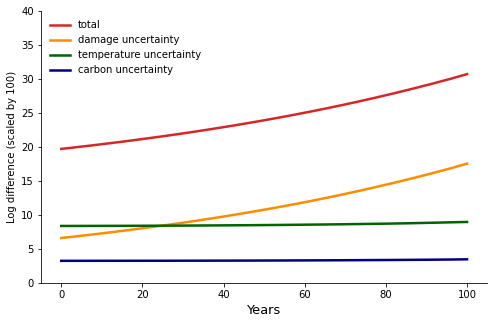

In [11]:
plt.figure(figsize=(8, 5))

_, _, total_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_total/ME_baseline)*(100), θ=np.mean(θ), y_start=np.mean(θ)*290, T=100)
_, _, temp_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_temp/ME_baseline)*(100), θ=np.mean(θ), y_start=np.mean(θ)*290, T=100)
_, _, carb_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_carb/ME_baseline)*(100), θ=np.mean(θ), y_start=np.mean(θ)*290, T=100)
_, _, damage_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_damage/ME_baseline)*(100), θ=np.mean(θ), y_start=np.mean(θ)*290, T=100)

# plt.plot(y_grid_short, np.log(ME_total/ME_baseline)*(100), label='total', color='tab:red', linewidth=2.5)
# plt.plot(y_grid_short, np.log(ME_temp/ME_baseline)*(100), label='temperature uncertainty', color='darkorange', linewidth=2.5)
# plt.plot(y_grid_short, np.log(ME_carb/ME_baseline)*(100), label='carbon uncertainty', color='darkgreen', linewidth=2.5)
# plt.plot(y_grid_short, np.log(ME_damage/ME_baseline)*(100), label='damage uncertainty', color='navy', linewidth=2.5)
# plt.xlabel('Temperature anomaly', fontsize=13)

plt.plot(total_t, label='total', color='tab:red', linewidth=2.5)
plt.plot(damage_t, label='damage uncertainty', color='darkorange', linewidth=2.5)
plt.plot(temp_t, label='temperature uncertainty', color='darkgreen', linewidth=2.5)
plt.plot(carb_t, label='carbon uncertainty', color='navy', linewidth=2.5)
plt.xlabel('Years', fontsize=13)

plt.ylabel(r'Log difference (scaled by 100)')
plt.legend(frameon=False, loc='upper left')
plt.ylim(0, 40)
plt.savefig('../plots/standardized/uncertainty_one_partition.pdf')

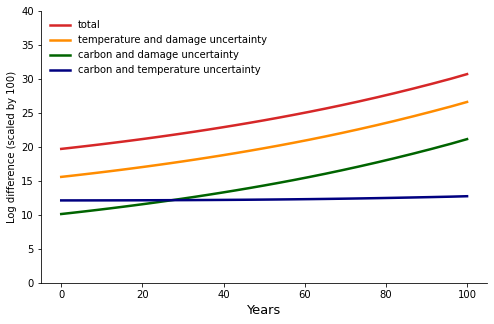

In [12]:
plt.figure(figsize=(8, 5))

_, _, total_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_total/ME_baseline)*(100), θ=np.mean(θ), y_start=np.mean(θ)*290, T=100)
_, _, temp_damage_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_temp_damage/ME_baseline)*(100), θ=np.mean(θ), y_start=np.mean(θ)*290, T=100)
_, _, carb_damage_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_carb_damage/ME_baseline)*(100), θ=np.mean(θ), y_start=np.mean(θ)*290, T=100)
_, _, temp_carb_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_temp_carb/ME_baseline)*(100), θ=np.mean(θ), y_start=np.mean(θ)*290, T=100)

# plt.plot(y_grid_short, np.log(ME_total/ME_baseline)*(100), label='total', color='tab:red', linewidth=2.5)
# plt.plot(y_grid_short, np.log(ME_temp_damage/ME_baseline)*(100), label='temperature and damage uncertainty', color='darkorange', linewidth=2.5)
# plt.plot(y_grid_short, np.log(ME_carb_damage/ME_baseline)*(100), label='carbon and damage uncertainty', color='darkgreen', linewidth=2.5)
# plt.plot(y_grid_short, np.log(ME_temp_carb/ME_baseline)*(100), label='carbon and temperature uncertainty', color='navy', linewidth=2.5)
# plt.xlabel('Temperature anomaly', fontsize=13)

plt.plot(total_t, label='total', color='tab:red', linewidth=2.5)
plt.plot(temp_damage_t, label='temperature and damage uncertainty', color='darkorange', linewidth=2.5)
plt.plot(carb_damage_t, label='carbon and damage uncertainty', color='darkgreen', linewidth=2.5)
plt.plot(temp_carb_t, label='carbon and temperature uncertainty', color='navy', linewidth=2.5)
plt.xlabel('Years', fontsize=13)

plt.ylabel(r'Log difference (scaled by 100)')
plt.legend(frameon=False, loc='upper left')
plt.ylim(0, 40)
plt.savefig('../plots/standardized/uncertainty_two_partition.pdf')

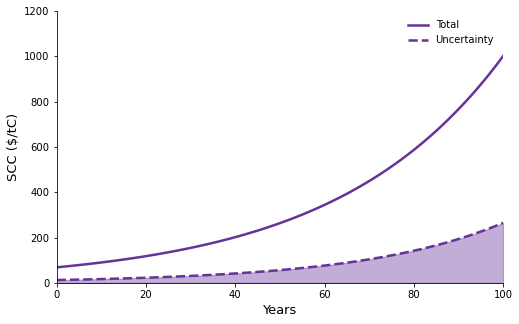

In [13]:
# 5. Plot SCC

et_tilde, yt, ratio_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      ME_baseline/ME_total, θ=np.mean(θ), y_start=np.mean(θ)*290, T=100)

# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
η = .032
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

SCCt_all = η*(0.025)*Kt/((1.-η)*et_tilde) * 1000
SCCt_baseline = SCCt_all * ratio_t
SCCt_uncertainty = SCCt_all - SCCt_baseline

plt.figure(figsize=(8, 5))
plt.plot(SCCt_all, color='rebeccapurple', label='Total', linewidth=2.5)
plt.plot(SCCt_uncertainty, color='rebeccapurple', label='Uncertainty', linestyle='dashed', linewidth=2.5)
plt.fill_between(np.arange(0, 101, 1), np.zeros_like(SCCt_uncertainty), 
                 SCCt_uncertainty, color='rebeccapurple', alpha=.4)
plt.ylim(0, 1200)
plt.xlim(0, 100)
plt.xlabel('Years', fontsize=13)
plt.ylabel('SCC ($/tC)', fontsize=13)
plt.legend(frameon=False)
plt.savefig('../plots/standardized/scc.pdf')

Evolution of damages:

$$
d \log N_t = \mu_n(Y_t, F_t) dt + \sigma_n(Y_t, F_t) \cdot dW_t
$$

where

$$
\mu_n(y, f) = \left(\gamma_1 + \gamma_2 y\right) \mu_y(f) + \frac{1}{2}\gamma_2|\sigma_y(f)|^2
$$

and

$$
\sigma_n(y, f) = \left(\gamma_1 + \gamma_2 y\right) \sigma_y (f)
$$

where $\mu_y(f) = f \sum_{i=1}^n \pi^a_i \theta_i$ and $\sigma_y(f) =  f\zeta$.

In [14]:
# Smimulate damages
γ_1 = 1.7675/10000
γ_2 = .0022*2
θ_reshape = np.zeros_like(model['πc'])
for i in range(θ_reshape.shape[0]):
    θ_reshape[i] = model['θ'][i]
mu_y = model['e_tilde'] * np.sum(model['πc']*θ_reshape, axis=0)
sigma_y = model['e_tilde'] * model['σ_y']
mu_n = (γ_1 + γ_2 * model['y_grid']) * mu_y + .5 * γ_2 * sigma_y**2
sigma_n = (γ_1 + γ_2 * model['y_grid']) * sigma_y

In [15]:
@njit
def simulation_damage(y_grid, e_grid, mu_n_grid, sigma_n_grid, 
                      mu_y_grid, sigma_y_grid, Ws, y_start=.5394):
    n_path, T = Ws.shape
    log_N = np.zeros((n_path, T+1))
    for n in range(n_path):
        y = y_start
        for t in range(1, T+1):
            # Updtea drift and diffusion
            mu_n_t = np.interp(y, y_grid, mu_n_grid)
            sigma_n_t = np.interp(y, y_grid, sigma_n_grid)
            log_N[n, t] = log_N[n, t-1] + mu_n_t + sigma_n_t * Ws[n, t-1]
            # Update y
            e_t = np.interp(y, y_grid, e_grid)
            mu_y_t = np.interp(y, y_grid, mu_y_grid)
            sigma_y_t = np.interp(y, y_grid, sigma_y_grid)
            y = y + mu_y_t + sigma_y_t * Ws[n, t-1]
    return log_N

In [16]:
T = 100
n_path = 100_000
Ws = np.random.normal(0., 1., (n_path, T))

In [17]:
log_N = simulation_damage(model['y_grid'], model['e_tilde'], mu_n, sigma_n,
                          mu_y, sigma_y, Ws, y_start=.5394)
N = np.exp(log_N)

In [18]:
# N_10 = np.percentile(N, 10, axis=0)
# N_50 = np.percentile(N, 50, axis=0)
# N_90 = np.percentile(N, 90, axis=0)

log_N_10 = np.percentile(log_N, 10, axis=0)
log_N_50 = np.percentile(log_N, 50, axis=0)
log_N_90 = np.percentile(log_N, 90, axis=0)

In [19]:
plt.plot(1/N_10)
plt.plot(1/N_50)
plt.plot(1/N_90)

NameError: name 'N_10' is not defined

In [ ]:
plt.plot(log_N_10*100, label='.1 percentile')
plt.plot(log_N_50*100, label='.5 percentile')
plt.plot(log_N_90*100, label='.9 percentile')
plt.xlabel('Years')
plt.title(r'$\log N_t$ * 100')
plt.legend(frameon=False)

In [ ]:
1.86/1000 * 1.2 * .186 * 1000 # 1/600

In [ ]:
1.86/1000 * 1.2 * .132 * 1000 # 1/400

In [ ]:
1.86/1000 * 1.2 * .12 * 1000 # 1/360

In [ ]:
1.86/1000 * 1.2 * .117 * 1000 # 1/350

In [ ]:
1.86/1000 * 1.2 * .114 * 1000 # 1/340

In [ ]:
1.86/1000 * 1.2 * .102 * 1000 # 1/300